In [2]:
%matplotlib notebook

import csv
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FormatStrFormatter)

# ANN1 analysis

## stdev-based function analysis

In [3]:
dff = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/stdev/irsim-ANN1/geneticDataFiles/fitness.log", sep="\t", header=0, names=["gen", "best", "avg", "worst"], skiprows=2)
dff = dff[:1001]
dff.describe()

,gen,best,avg,worst
count,1001.000000,1001.000000,1001.000000,1001.0
mean,500.000000,0.538487,0.351497,0.0
std,289.108111,0.007891,0.024680,0.0
min,0.000000,0.395251,0.121814,0.0
25%,250.000000,0.539032,0.338388,0.0
50%,500.000000,0.540056,0.351510,0.0
75%,750.000000,0.540056,0.366805,0.0
max,1000.000000,0.542584,0.409839,0.0


<IPython.core.display.Javascript object>


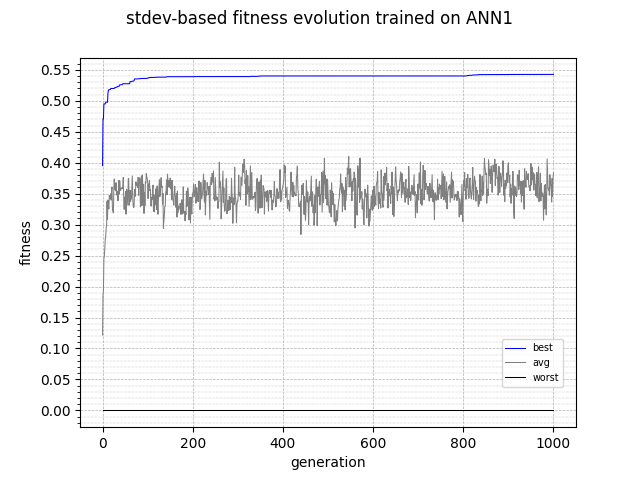

In [240]:
fig = plt.figure()
ax = fig.gca()
bestf = dff.plot(x="gen", y="best", ax=ax, c="blue", linewidth=0.75, legend=False)
avgf = dff.plot(x="gen", y="avg", ax=ax, c="grey", linewidth=0.75, legend=False)
worstf = dff.plot(x="gen", y="worst", ax=ax, c="black", linewidth=0.75, legend=False)
ax.patch.set_visible(False)

In [241]:
ax.set_xlabel("generation")
ax.set_ylabel("fitness")
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
#ax.set_ylim(bottom=0.25)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('stdev-based fitness evolution trained on ANN1')
axbox = ax.get_position()
ax.legend(fontsize="x-small", loc=(axbox.x1 - 0.05, axbox.y0))

In [242]:
fig.savefig("figures/ann1_stdev_fitness.pdf", bbox_inches='tight')

## stdev-based battery charge analysis

In [243]:
dfyb = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/stdev/irsim-ANN1/outputFiles/layer1Output", sep=" ", header=0, names=["time", "input", "battery[0]", "nan"], usecols=[0, 1, 2])
dfbb = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/stdev/irsim-ANN1/outputFiles/layer2Output", sep=" ", header=0, names=["time", "input", "blueBattery[0]", "nan"], usecols=[0, 1, 2])
dfyb = dfyb[:2001]
dfbb = dfbb[:2001]
dfstat = dfyb[["time"]].copy()
dfstat["yb"] = dfyb[["battery[0]"]].copy()
dfstat["bb"] = dfbb[["blueBattery[0]"]].copy()
dfstat["cstd"] = dfstat[["yb", "bb"]].std(axis=1)
dfstat

,time,yb,bb,cstd
0,0.1,0.990,0.990,0.0
1,0.2,0.985,0.985,0.0
2,0.3,0.980,0.980,0.0
3,0.4,0.975,0.975,0.0
4,0.5,0.970,0.970,0.0
...,...,...,...,...
1996,199.7,0.000,0.000,0.0
1997,199.8,0.000,0.000,0.0
1998,199.9,0.000,0.000,0.0
1999,200.0,0.000,0.000,0.0


<IPython.core.display.Javascript object>


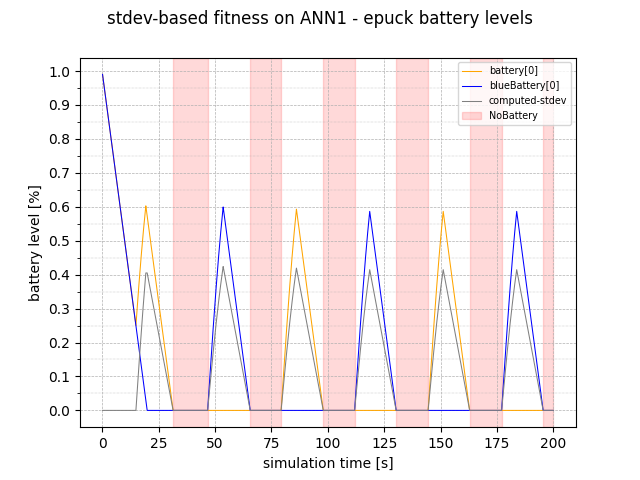

In [244]:
fig = plt.figure()
ax = fig.gca()
yb = dfyb.plot(x="time", y="battery[0]", ax=ax, c="orange", linewidth=0.75, legend=False)
bb = dfbb.plot(x="time", y="blueBattery[0]", ax=ax, c="blue", linewidth=0.75, legend=False)
istd = dfstat.plot(x="time", y="cstd", ax=ax, c="grey", linewidth=0.75, label="computed-stdev", legend=False)
ax.patch.set_visible(False)

In [245]:
# tag rows based on the threshold
dfstat['zero'] = (dfyb['battery[0]'] == dfbb['blueBattery[0]']) & (dfyb['battery[0]'] == 0)

# first row is a True preceded by a False
fst = dfstat.index[dfstat['zero'] & ~ dfstat['zero'].shift(1).fillna(False)]

# last row is a True followed by a False
lst = dfstat.index[dfstat['zero'] & ~ dfstat['zero'].shift(-1).fillna(False)]

# filter those which are adequately apart
depleted_regions = [(i, j) for i, j in zip(fst, lst)]
depleted_regions

[(313, 466), (655, 792), (979, 1118), (1303, 1444), (1629, 1770), (1955, 2000)]

In [246]:
# paint red squares for the regions with no charge
for tup in depleted_regions:
    avs = ax.axvspan(dfyb.iloc[tup[0]]["time"], dfyb.iloc[tup[1]]["time"], alpha=0.15, color='red', label = "NoBattery")

In [247]:
ax.set_xlabel("simulation time [s]")
ax.set_ylabel("battery level [%]")
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(bottom=0.25)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('stdev-based fitness on ANN1 - epuck battery levels')
lns = [yb.get_lines()[0]] + [bb.get_lines()[1]] + [istd.get_lines()[2]] + [avs]
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, fontsize="x-small", loc="upper right")

In [248]:
fig.savefig("figures/ann1_stdev_battery.pdf", bbox_inches='tight')

## stdev-based light sensors analysis

In [249]:
dfbl = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/stdev/irsim-ANN1/outputFiles/layer4Output", sep=" ", header=None, names=["time", "bl0", "bl7"], usecols=[0, 1, 8])
dfyl = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/stdev/irsim-ANN1/outputFiles/layer2Output", sep=" ", header=None, names=["time", "l0", "l7"], usecols=[0, 1, 8])
dfbl["l0"] = dfyl["l0"]
dfbl["l7"] = dfyl["l7"]
dfbl["bmean"] = dfbl[["bl0", "bl7"]].mean(axis=1)
dfbl["ymean"] = dfbl[["l0", "l7"]].mean(axis=1)
dfbl = dfbl[:2001]
dfbl

,time,bl0,bl7,l0,l7,bmean,ymean
0,0.0,0.4428,0.0000,0.995,NaN,0.22140,0.995
1,0.1,0.4502,0.0000,0.990,NaN,0.22510,0.990
2,0.2,0.4574,0.0000,0.985,NaN,0.22870,0.985
3,0.3,0.4643,0.0000,0.980,NaN,0.23215,0.980
4,0.4,0.4711,0.0048,0.975,NaN,0.23795,0.975
...,...,...,...,...,...,...,...
1996,199.6,0.2142,0.5956,0.000,NaN,0.40490,0.000
1997,199.7,0.2154,0.5955,0.000,NaN,0.40545,0.000
1998,199.8,0.2167,0.5954,0.000,NaN,0.40605,0.000
1999,199.9,0.2179,0.5953,0.000,NaN,0.40660,0.000


<IPython.core.display.Javascript object>


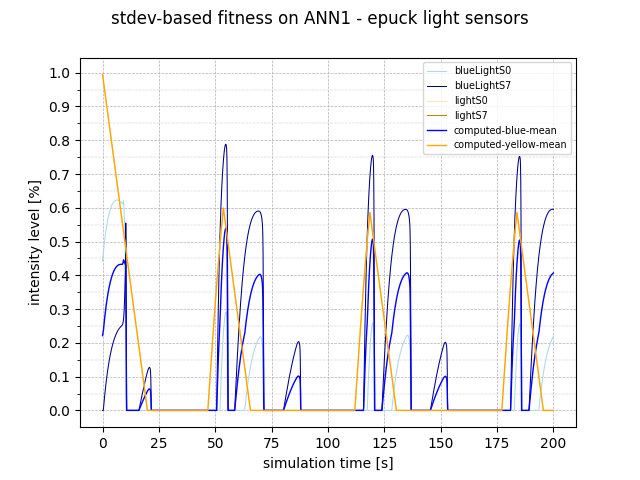

In [250]:
fig = plt.figure()
ax = fig.gca()
bl0 = dfbl.plot(x="time", y="bl0", ax=ax, c="lightblue", linewidth=0.75, label="blueLightS0", legend=False)
bl7 = dfbl.plot(x="time", y="bl7", ax=ax, c="darkblue", linewidth=0.75, label="blueLightS7", legend=False)
l0 = dfbl.plot(x="time", y="l0", ax=ax, c="moccasin", linewidth=0.75, label="lightS0", legend=False)
l7 = dfbl.plot(x="time", y="l7", ax=ax, c="darkgoldenrod", linewidth=0.75, label="lightS7", legend=False)
bmean = dfbl.plot(x="time", y="bmean", ax=ax, c="blue", linewidth=1, label="computed-blue-mean", legend=False)
ymean = dfbl.plot(x="time", y="ymean", ax=ax, c="orange", linewidth=1, label="computed-yellow-mean", legend=False)
ax.patch.set_visible(False)

In [251]:
ax.set_xlabel("simulation time [s]")
ax.set_ylabel("intensity level [%]")
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(top=1.4)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('stdev-based fitness on ANN1 - epuck light sensors')
yb = ax.get_position()
ax.legend(fontsize="x-small", loc=0)

In [252]:
fig.savefig("figures/ann1_stdev_light.pdf", bbox_inches='tight')

## hysteresis-based function analysis

In [4]:
dff = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-ANN1/geneticDataFiles/fitness.log", sep="\t", header=0, names=["gen", "best", "avg", "worst"], skiprows=2)
dff = dff[:1001]
dff.describe()

,gen,best,avg,worst
count,1001.000000,1001.000000,1001.000000,1001.0
mean,500.000000,0.687894,0.416130,0.0
std,289.108111,0.024958,0.044804,0.0
min,0.000000,0.419139,0.093753,0.0
25%,250.000000,0.660955,0.400280,0.0
50%,500.000000,0.702367,0.423044,0.0
75%,750.000000,0.703065,0.443770,0.0
max,1000.000000,0.703805,0.503383,0.0


<IPython.core.display.Javascript object>


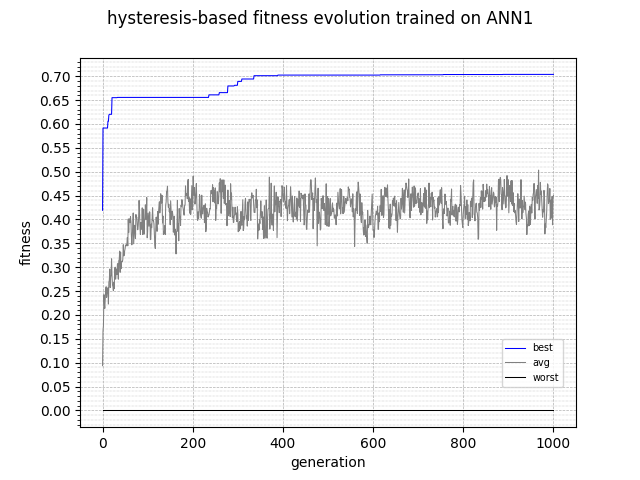

In [254]:
fig = plt.figure()
ax = fig.gca()
bestf = dff.plot(x="gen", y="best", ax=ax, c="blue", linewidth=0.75, legend=False)
avgf = dff.plot(x="gen", y="avg", ax=ax, c="grey", linewidth=0.75, legend=False)
worstf = dff.plot(x="gen", y="worst", ax=ax, c="black", linewidth=0.75, legend=False)
ax.patch.set_visible(False)

In [255]:
ax.set_xlabel("generation")
ax.set_ylabel("fitness")
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
#ax.set_ylim(bottom=0.25)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('hysteresis-based fitness evolution trained on ANN1')
axbox = ax.get_position()
ax.legend(fontsize="x-small", loc=(axbox.x1 - 0.05, axbox.y0))

In [256]:
fig.savefig("figures/ann1_schmitt_fitness.pdf", bbox_inches='tight')

## hysteresis-based battery charge analysis

In [257]:
dfyb = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-ANN1/outputFiles/layer1Output", sep=" ", header=0, names=["time", "input", "battery[0]", "nan"], usecols=[0, 1, 2])
dfbb = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-ANN1/outputFiles/layer2Output", sep=" ", header=0, names=["time", "input", "blueBattery[0]", "nan"], usecols=[0, 1, 2])
dfyb = dfyb[:2001]
dfbb = dfbb[:2001]
dfstat = dfyb[["time"]].copy()
dfstat["yb"] = dfyb[["battery[0]"]].copy()
dfstat["bb"] = dfbb[["blueBattery[0]"]].copy()
dfstat["mean"] = dfstat[["yb", "bb"]].mean(axis=1)
dfstat

,time,yb,bb,mean
0,0.1,0.9900,0.9900,0.99000
1,0.2,0.9850,0.9850,0.98500
2,0.3,0.9800,0.9800,0.98000
3,0.4,0.9750,0.9750,0.97500
4,0.5,0.9700,0.9700,0.97000
...,...,...,...,...
1996,199.7,0.3458,0.3379,0.34185
1997,199.8,0.3546,0.3329,0.34375
1998,199.9,0.3633,0.3279,0.34560
1999,200.0,0.3720,0.3229,0.34745


<IPython.core.display.Javascript object>


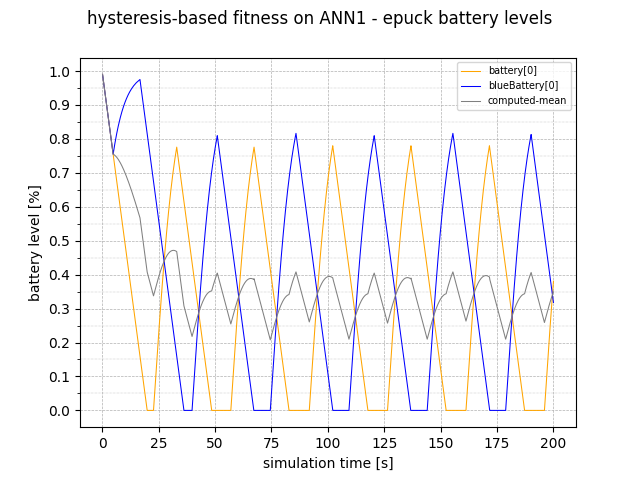

In [258]:
fig = plt.figure()
ax = fig.gca()
yb = dfyb.plot(x="time", y="battery[0]", ax=ax, c="orange", linewidth=0.75, legend=False)
bb = dfbb.plot(x="time", y="blueBattery[0]", ax=ax, c="blue", linewidth=0.75, legend=False)
#istd = dfstat.plot(x="time", y="cstd", ax=ax, c="grey", linewidth=0.75, label="computed-stdev", legend=False)
mean = dfstat.plot(x="time", y="mean", ax=ax, c="grey", linewidth=0.75, label="computed-mean", legend=False)
ax.patch.set_visible(False)

In [259]:
# tag rows based on the threshold
dfstat['zero'] = (dfyb['battery[0]'] == dfbb['blueBattery[0]']) & (dfyb['battery[0]'] == 0)

# first row is a True preceded by a False
fst = dfstat.index[dfstat['zero'] & ~ dfstat['zero'].shift(1).fillna(False)]

# last row is a True followed by a False
lst = dfstat.index[dfstat['zero'] & ~ dfstat['zero'].shift(-1).fillna(False)]

# filter those which are adequately apart
depleted_regions = [(i, j) for i, j in zip(fst, lst)]
depleted_regions

[]

In [260]:
# paint red squares for the regions with no charge
for tup in depleted_regions:
    avs = ax.axvspan(dfyb.iloc[tup[0]]["time"], dfyb.iloc[tup[1]]["time"], alpha=0.15, color='red', label = "NoBattery")

In [261]:
ax.set_xlabel("simulation time [s]")
ax.set_ylabel("battery level [%]")
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(bottom=0.25)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('hysteresis-based fitness on ANN1 - epuck battery levels')
ax.legend(fontsize="x-small", loc="upper right")

In [262]:
fig.savefig("figures/ann1_schmitt_battery.pdf", bbox_inches='tight')

## hysteresis-based light sensors analysis

In [263]:
dfbl = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-ANN1/outputFiles/layer4Output", sep=" ", header=None, names=["time", "bl0", "bl7"], usecols=[0, 1, 8])
dfyl = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-ANN1/outputFiles/layer3Output", sep=" ", header=None, names=["time", "l0", "l7"], usecols=[0, 1, 8])
dfbl["l0"] = dfyl["l0"]
dfbl["l7"] = dfyl["l7"]
dfbl["bmean"] = dfbl[["bl0", "bl7"]].mean(axis=1)
dfbl["ymean"] = dfbl[["l0", "l7"]].mean(axis=1)
dfbl = dfbl[:2001]
dfbl

,time,bl0,bl7,l0,l7,bmean,ymean
0,0.0,0.4428,0.0,0.0000,0.0000,0.22140,0.00000
1,0.1,0.4396,0.0,0.0000,0.0000,0.21980,0.00000
2,0.2,0.4363,0.0,0.0000,0.0000,0.21815,0.00000
3,0.3,0.4328,0.0,0.0000,0.0000,0.21640,0.00000
4,0.4,0.4292,0.0,0.0000,0.0000,0.21460,0.00000
...,...,...,...,...,...,...,...
1996,199.6,0.0000,0.0,0.7848,0.6296,0.00000,0.70720
1997,199.7,0.0000,0.0,0.8023,0.6158,0.00000,0.70905
1998,199.8,0.0000,0.0,0.8303,0.5914,0.00000,0.71085
1999,199.9,0.0000,0.0,0.8831,0.5422,0.00000,0.71265


<IPython.core.display.Javascript object>


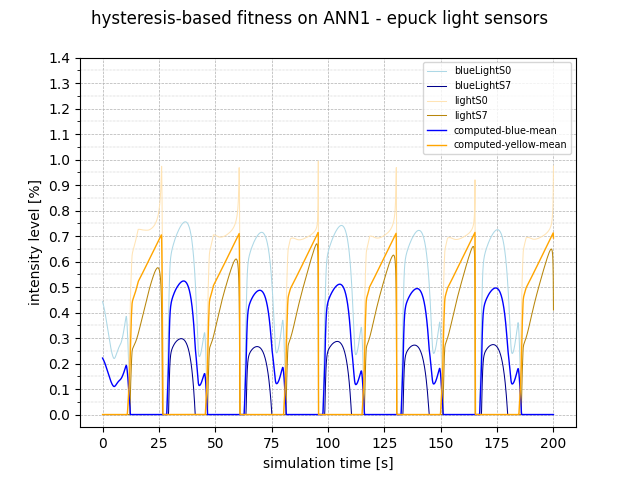

In [264]:
fig = plt.figure()
ax = fig.gca()
bl0 = dfbl.plot(x="time", y="bl0", ax=ax, c="lightblue", linewidth=0.75, label="blueLightS0", legend=False)
bl7 = dfbl.plot(x="time", y="bl7", ax=ax, c="darkblue", linewidth=0.75, label="blueLightS7", legend=False)
l0 = dfbl.plot(x="time", y="l0", ax=ax, c="moccasin", linewidth=0.75, label="lightS0", legend=False)
l7 = dfbl.plot(x="time", y="l7", ax=ax, c="darkgoldenrod", linewidth=0.75, label="lightS7", legend=False)
bmean = dfbl.plot(x="time", y="bmean", ax=ax, c="blue", linewidth=1, label="computed-blue-mean", legend=False)
ymean = dfbl.plot(x="time", y="ymean", ax=ax, c="orange", linewidth=1, label="computed-yellow-mean", legend=False)
ax.patch.set_visible(False)

In [265]:
ax.set_xlabel("simulation time [s]")
ax.set_ylabel("intensity level [%]")
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(top=1.4)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('hysteresis-based fitness on ANN1 - epuck light sensors')
yb = ax.get_position()
ax.legend(fontsize="x-small", loc=0)

In [266]:
fig.savefig("figures/ann1_schmitt_light.pdf", bbox_inches='tight')

# ANN2 analysis

## stdev-based function analysis

In [5]:
dff = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/stdev/irsim-ANN2/geneticDataFiles/fitness.log", sep="\t", header=0, names=["gen", "best", "avg", "worst"], skiprows=2)
dff = dff[:1001]
dff.describe()

,gen,best,avg,worst
count,1001.000000,1001.000000,1001.000000,1001.0
mean,500.000000,0.546095,0.315367,0.0
std,289.108111,0.012577,0.030209,0.0
min,0.000000,0.309250,0.064144,0.0
25%,250.000000,0.547601,0.302025,0.0
50%,500.000000,0.548551,0.318121,0.0
75%,750.000000,0.548978,0.332508,0.0
max,1000.000000,0.548978,0.391045,0.0


<IPython.core.display.Javascript object>


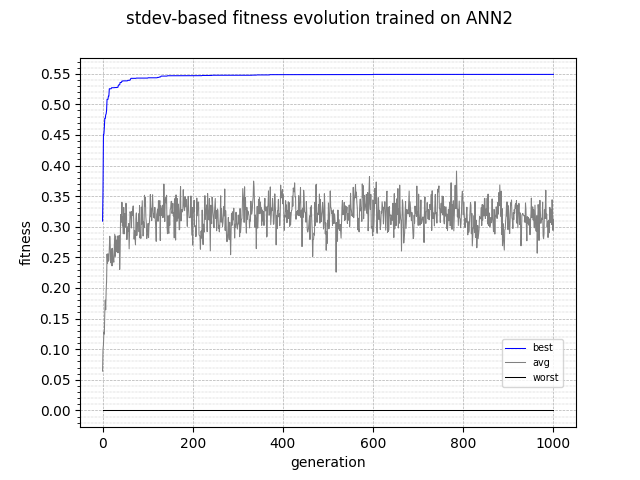

In [268]:
fig = plt.figure()
ax = fig.gca()
bestf = dff.plot(x="gen", y="best", ax=ax, c="blue", linewidth=0.75, legend=False)
avgf = dff.plot(x="gen", y="avg", ax=ax, c="grey", linewidth=0.75, legend=False)
worstf = dff.plot(x="gen", y="worst", ax=ax, c="black", linewidth=0.75, legend=False)
ax.patch.set_visible(False)

In [269]:
ax.set_xlabel("generation")
ax.set_ylabel("fitness")
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
#ax.set_ylim(bottom=0.25)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('stdev-based fitness evolution trained on ANN2')
axbox = ax.get_position()
ax.legend(fontsize="x-small", loc=(axbox.x1 - 0.05, axbox.y0))

In [270]:
fig.savefig("figures/ann2_stdev_fitness.pdf", bbox_inches='tight')

## stdev-based battery charge analysis

In [271]:
dfyb = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/stdev/irsim-ANN2/outputFiles/layer1Output", sep=" ", header=0, names=["time", "input", "battery[0]", "nan"], usecols=[0, 1, 2])
dfbb = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/stdev/irsim-ANN2/outputFiles/layer3Output", sep=" ", header=0, names=["time", "input", "blueBattery[0]", "nan"], usecols=[0, 1, 2])
dfyb = dfyb[:2001]
dfbb = dfbb[:2001]
dfstat = dfyb[["time"]].copy()
dfstat["yb"] = dfyb[["battery[0]"]].copy()
dfstat["bb"] = dfbb[["blueBattery[0]"]].copy()
dfstat["cstd"] = dfstat[["yb", "bb"]].std(axis=1)
dfstat

,time,yb,bb,cstd
0,0.1,0.9900,0.990,0.000000
1,0.2,0.9850,0.985,0.000000
2,0.3,0.9800,0.980,0.000000
3,0.4,0.9750,0.975,0.000000
4,0.5,0.9700,0.970,0.000000
...,...,...,...,...
1996,199.7,0.3901,0.000,0.275842
1997,199.8,0.3851,0.000,0.272307
1998,199.9,0.3801,0.000,0.268771
1999,200.0,0.3751,0.000,0.265236


<IPython.core.display.Javascript object>


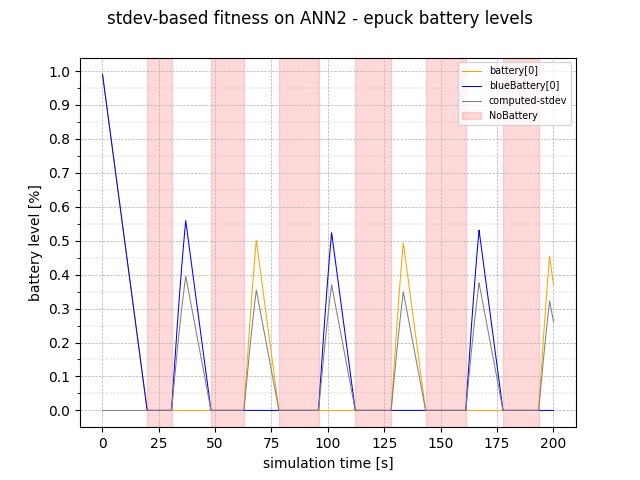

In [272]:
fig = plt.figure()
ax = fig.gca()
yb = dfyb.plot(x="time", y="battery[0]", ax=ax, c="orange", linewidth=0.75, legend=False)
bb = dfbb.plot(x="time", y="blueBattery[0]", ax=ax, c="blue", linewidth=0.75, legend=False)
istd = dfstat.plot(x="time", y="cstd", ax=ax, c="grey", linewidth=0.75, label="computed-stdev", legend=False)
ax.patch.set_visible(False)

In [273]:
# tag rows based on the threshold
dfstat['zero'] = (dfyb['battery[0]'] == dfbb['blueBattery[0]']) & (dfyb['battery[0]'] == 0)

# first row is a True preceded by a False
fst = dfstat.index[dfstat['zero'] & ~ dfstat['zero'].shift(1).fillna(False)]

# last row is a True followed by a False
lst = dfstat.index[dfstat['zero'] & ~ dfstat['zero'].shift(-1).fillna(False)]

# filter those which are adequately apart
depleted_regions = [(i, j) for i, j in zip(fst, lst)]
depleted_regions

[(198, 306), (481, 627), (783, 958), (1121, 1280), (1433, 1611), (1777, 1934)]

In [274]:
# paint red squares for the regions with no charge
for tup in depleted_regions:
    avs = ax.axvspan(dfyb.iloc[tup[0]]["time"], dfyb.iloc[tup[1]]["time"], alpha=0.15, color='red', label = "NoBattery")

In [275]:
ax.set_xlabel("simulation time [s]")
ax.set_ylabel("battery level [%]")
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(bottom=0.25)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('stdev-based fitness on ANN2 - epuck battery levels')
lns = [yb.get_lines()[0]] + [bb.get_lines()[1]] + [istd.get_lines()[2]] + [avs]
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, fontsize="x-small", loc="upper right")

In [276]:
fig.savefig("figures/ann2_stdev_battery.pdf", bbox_inches='tight')

## stdev-based light sensors analysis

In [277]:
dfbl = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/stdev/irsim-ANN2/outputFiles/layer4Output", sep=" ", header=None, names=["time", "bl0", "bl7"], usecols=[0, 1, 8])
dfyl = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/stdev/irsim-ANN2/outputFiles/layer2Output", sep=" ", header=None, names=["time", "l0", "l7"], usecols=[0, 1, 8])
dfbl["l0"] = dfyl["l0"]
dfbl["l7"] = dfyl["l7"]
dfbl["bmean"] = dfbl[["bl0", "bl7"]].mean(axis=1)
dfbl["ymean"] = dfbl[["l0", "l7"]].mean(axis=1)
dfbl = dfbl[:2001]
dfbl

,time,bl0,bl7,l0,l7,bmean,ymean
0,0.0,0.0,0.0,0.4428,0.0,0.0,0.22140
1,0.1,0.0,0.0,0.4351,0.0,0.0,0.21755
2,0.2,0.0,0.0,0.4271,0.0,0.0,0.21355
3,0.3,0.0,0.0,0.4189,0.0,0.0,0.20945
4,0.4,0.0,0.0,0.4105,0.0,0.0,0.20525
...,...,...,...,...,...,...,...
1996,199.6,0.0,0.0,0.0000,0.0,0.0,0.00000
1997,199.7,0.0,0.0,0.0000,0.0,0.0,0.00000
1998,199.8,0.0,0.0,0.0000,0.0,0.0,0.00000
1999,199.9,0.0,0.0,0.0000,0.0,0.0,0.00000


<IPython.core.display.Javascript object>


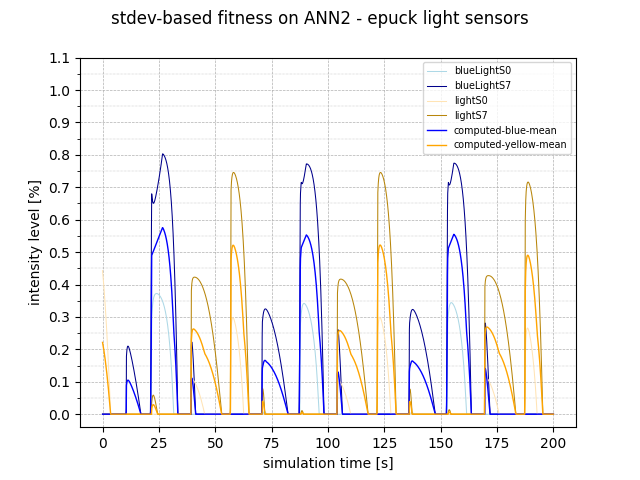

In [278]:
fig = plt.figure()
ax = fig.gca()
bl0 = dfbl.plot(x="time", y="bl0", ax=ax, c="lightblue", linewidth=0.75, label="blueLightS0", legend=False)
bl7 = dfbl.plot(x="time", y="bl7", ax=ax, c="darkblue", linewidth=0.75, label="blueLightS7", legend=False)
l0 = dfbl.plot(x="time", y="l0", ax=ax, c="moccasin", linewidth=0.75, label="lightS0", legend=False)
l7 = dfbl.plot(x="time", y="l7", ax=ax, c="darkgoldenrod", linewidth=0.75, label="lightS7", legend=False)
bmean = dfbl.plot(x="time", y="bmean", ax=ax, c="blue", linewidth=1, label="computed-blue-mean", legend=False)
ymean = dfbl.plot(x="time", y="ymean", ax=ax, c="orange", linewidth=1, label="computed-yellow-mean", legend=False)
ax.patch.set_visible(False)

In [279]:
ax.set_xlabel("simulation time [s]")
ax.set_ylabel("intensity level [%]")
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(top=1.1)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('stdev-based fitness on ANN2 - epuck light sensors')
yb = ax.get_position()
ax.legend(fontsize="x-small", loc=0)

In [280]:
fig.savefig("figures/ann2_stdev_light.pdf", bbox_inches='tight')

## hysteresis-based function analysis

In [6]:
dff = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-ANN2/geneticDataFiles/fitness.log", sep="\t", header=0, names=["gen", "best", "avg", "worst"], skiprows=2)
dff = dff[:1001]
dff.describebe()

,gen,best,avg,worst
count,1001.000000,1001.000000,1001.000000,1001.0
mean,500.000000,0.948175,0.299114,0.0
std,289.108111,0.047302,0.036589,0.0
min,0.000000,0.326595,0.044433,0.0
25%,250.000000,0.960470,0.278521,0.0
50%,500.000000,0.960470,0.300823,0.0
75%,750.000000,0.960470,0.322299,0.0
max,1000.000000,0.960470,0.393195,0.0


<IPython.core.display.Javascript object>


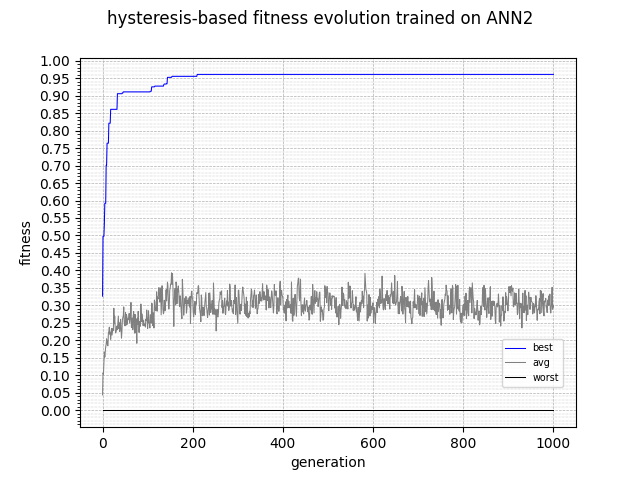

In [282]:
fig = plt.figure()
ax = fig.gca()
bestf = dff.plot(x="gen", y="best", ax=ax, c="blue", linewidth=0.75, legend=False)
avgf = dff.plot(x="gen", y="avg", ax=ax, c="grey", linewidth=0.75, legend=False)
worstf = dff.plot(x="gen", y="worst", ax=ax, c="black", linewidth=0.75, legend=False)
ax.patch.set_visible(False)

In [283]:
ax.set_xlabel("generation")
ax.set_ylabel("fitness")
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
#ax.set_ylim(bottom=0.25)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('hysteresis-based fitness evolution trained on ANN2')
axbox = ax.get_position()
ax.legend(fontsize="x-small", loc=(axbox.x1 - 0.05, axbox.y0))

In [284]:
fig.savefig("figures/ann2_schmitt_fitness.pdf", bbox_inches='tight')

## hysteresis-based battery charge analysis

In [285]:
dfyb = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-ANN2/outputFiles/layer1Output", sep=" ", header=0, names=["time", "input", "battery[0]", "nan"], usecols=[0, 1, 2])
dfbb = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-ANN2/outputFiles/layer3Output", sep=" ", header=0, names=["time", "input", "blueBattery[0]", "nan"], usecols=[0, 1, 2])
dfyb = dfyb[:2001]
dfbb = dfbb[:2001]
dfstat = dfyb[["time"]].copy()
dfstat["yb"] = dfyb[["battery[0]"]].copy()
dfstat["bb"] = dfbb[["blueBattery[0]"]].copy()
dfstat["cstd"] = dfstat[["yb", "bb"]].std(axis=1)
dfstat

,time,yb,bb,cstd
0,0.1,0.990,0.990,0.000000
1,0.2,0.985,0.985,0.000000
2,0.3,0.980,0.980,0.000000
3,0.4,0.975,0.975,0.000000
4,0.5,0.970,0.970,0.000000
...,...,...,...,...
1996,199.7,1.000,0.000,0.707107
1997,199.8,1.000,0.000,0.707107
1998,199.9,1.000,0.000,0.707107
1999,200.0,1.000,0.000,0.707107


<IPython.core.display.Javascript object>


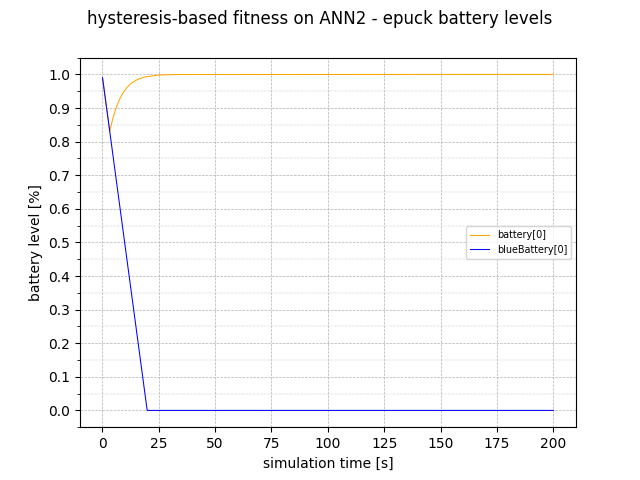

In [286]:
fig = plt.figure()
ax = fig.gca()
yb = dfyb.plot(x="time", y="battery[0]", ax=ax, c="orange", linewidth=0.75, legend=False)
bb = dfbb.plot(x="time", y="blueBattery[0]", ax=ax, c="blue", linewidth=0.75, legend=False)
#istd = dfstat.plot(x="time", y="cstd", ax=ax, c="grey", linewidth=0.75, label="computed-stdev", legend=False)
ax.patch.set_visible(False)

In [287]:
# tag rows based on the threshold
dfstat['zero'] = (dfyb['battery[0]'] == dfbb['blueBattery[0]']) & (dfyb['battery[0]'] == 0)

# first row is a True preceded by a False
fst = dfstat.index[dfstat['zero'] & ~ dfstat['zero'].shift(1).fillna(False)]

# last row is a True followed by a False
lst = dfstat.index[dfstat['zero'] & ~ dfstat['zero'].shift(-1).fillna(False)]

# filter those which are adequately apart
depleted_regions = [(i, j) for i, j in zip(fst, lst)]
depleted_regions

[]

In [288]:
# paint red squares for the regions with no charge
for tup in depleted_regions:
    avs = ax.axvspan(dfyb.iloc[tup[0]]["time"], dfyb.iloc[tup[1]]["time"], alpha=0.15, color='red', label = "NoBattery")

In [289]:
ax.set_xlabel("simulation time [s]")
ax.set_ylabel("battery level [%]")
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(bottom=0.25)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('hysteresis-based fitness on ANN2 - epuck battery levels')
lns = [yb.get_lines()[0]] + [bb.get_lines()[1]]
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, fontsize="x-small", loc=0)

In [290]:
fig.savefig("figures/ann2_schmitt_battery.pdf", bbox_inches='tight')

## hysteresis-based light sensors analysis

In [291]:
dfbl = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-ANN2/outputFiles/layer4Output", sep=" ", header=None, names=["time", "bl0", "bl7"], usecols=[0, 1, 8])
dfyl = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-ANN2/outputFiles/layer2Output", sep=" ", header=None, names=["time", "l0", "l7"], usecols=[0, 1, 8])
dfbl["l0"] = dfyl["l0"]
dfbl["l7"] = dfyl["l7"]
dfbl["bmean"] = dfbl[["bl0", "bl7"]].mean(axis=1)
dfbl["ymean"] = dfbl[["l0", "l7"]].mean(axis=1)
dfbl = dfbl[:2001]
dfbl

,time,bl0,bl7,l0,l7,bmean,ymean
0,0.0,0.0000,0.0000,0.4428,0.0000,0.00000,0.22140
1,0.1,0.0000,0.0000,0.1479,0.0000,0.00000,0.07395
2,0.2,0.0000,0.0000,0.0000,0.0000,0.00000,0.00000
3,0.3,0.0000,0.1399,0.0000,0.0000,0.06995,0.00000
4,0.4,0.0000,0.3568,0.0000,0.0000,0.17840,0.00000
...,...,...,...,...,...,...,...
1996,199.6,0.4590,0.4908,0.0000,0.0000,0.47490,0.00000
1997,199.7,0.4575,0.4887,0.0000,0.3427,0.47310,0.17135
1998,199.8,0.4590,0.4908,0.0000,0.0000,0.47490,0.00000
1999,199.9,0.4575,0.4887,0.0000,0.3427,0.47310,0.17135


<IPython.core.display.Javascript object>


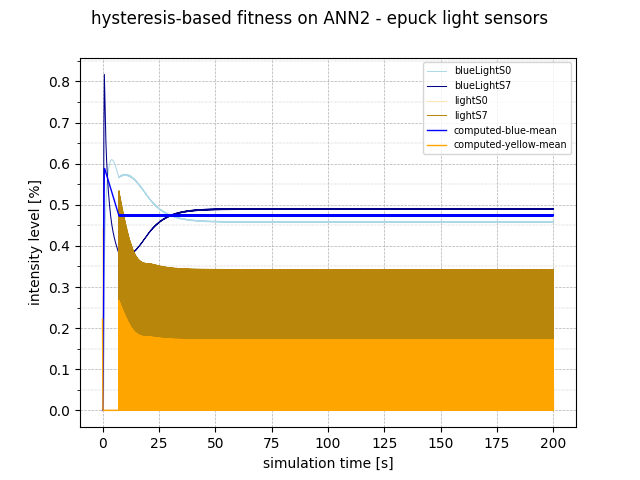

In [292]:
fig = plt.figure()
ax = fig.gca()
bl0 = dfbl.plot(x="time", y="bl0", ax=ax, c="lightblue", linewidth=0.75, label="blueLightS0", legend=False)
bl7 = dfbl.plot(x="time", y="bl7", ax=ax, c="darkblue", linewidth=0.75, label="blueLightS7", legend=False)
l0 = dfbl.plot(x="time", y="l0", ax=ax, c="moccasin", linewidth=0.75, label="lightS0", legend=False)
l7 = dfbl.plot(x="time", y="l7", ax=ax, c="darkgoldenrod", linewidth=0.75, label="lightS7", legend=False)
bmean = dfbl.plot(x="time", y="bmean", ax=ax, c="blue", linewidth=1, label="computed-blue-mean", legend=False)
ymean = dfbl.plot(x="time", y="ymean", ax=ax, c="orange", linewidth=1, label="computed-yellow-mean", legend=False)
ax.patch.set_visible(False)

In [293]:
ax.set_xlabel("simulation time [s]")
ax.set_ylabel("intensity level [%]")
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(top=1)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('hysteresis-based fitness on ANN2 - epuck light sensors')
yb = ax.get_position()
ax.legend(fontsize="x-small", loc=0)

In [294]:
fig.savefig("figures/ann2_schmitt_light.pdf", bbox_inches='tight')

# ANN3 analysis

## hysteresis-based function analysis

In [7]:
dff = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-ANN3/geneticDataFiles/fitness.log", sep="\t", header=None, names=["gen", "best", "avg", "worst"], comment="#")
dff = dff[:1001]
dff.describe()

,gen,best,avg,worst
count,1001.000000,1001.000000,1001.000000,1001.0
mean,500.000000,0.725130,0.337624,0.0
std,289.108111,0.032854,0.032808,0.0
min,0.000000,0.508767,0.070599,0.0
25%,250.000000,0.728938,0.317846,0.0
50%,500.000000,0.736892,0.338647,0.0
75%,750.000000,0.737500,0.358694,0.0
max,1000.000000,0.739563,0.424390,0.0


<IPython.core.display.Javascript object>


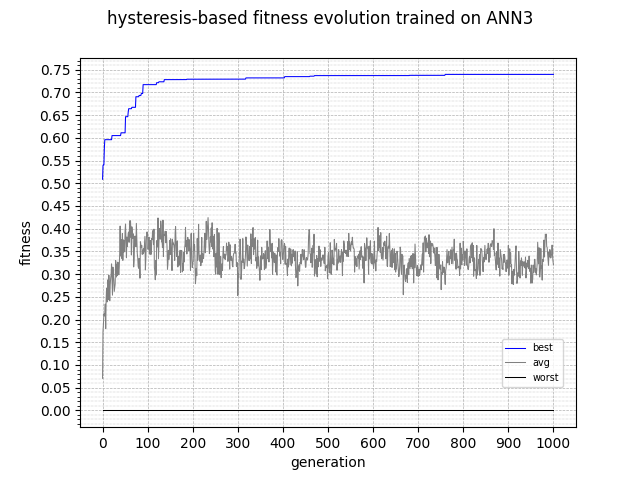

In [296]:
fig = plt.figure()
ax = fig.gca()
bestf = dff.plot(x="gen", y="best", ax=ax, c="blue", linewidth=0.75, legend=False)
avgf = dff.plot(x="gen", y="avg", ax=ax, c="grey", linewidth=0.75, legend=False)
worstf = dff.plot(x="gen", y="worst", ax=ax, c="black", linewidth=0.75, legend=False)
ax.patch.set_visible(False)

In [297]:
ax.set_xlabel("generation")
ax.set_ylabel("fitness")
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
#ax.set_ylim(bottom=0.25)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('hysteresis-based fitness evolution trained on ANN3')
axbox = ax.get_position()
ax.legend(fontsize="x-small", loc=(axbox.x1 - 0.05, axbox.y0))

In [298]:
fig.savefig("figures/ann3_schmitt_fitness.pdf", bbox_inches='tight')

## hysteresis-based battery charge analysis

In [299]:
dfyb = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-ANN3/outputFiles/layer1Output", sep=" ", header=0, names=["time", "input", "battery[0]", "nan"], usecols=[0, 1, 2])
dfbb = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-ANN3/outputFiles/layer3Output", sep=" ", header=0, names=["time", "input", "blueBattery[0]", "nan"], usecols=[0, 1, 2])
dfyb = dfyb[:2001]
dfbb = dfbb[:2001]
dfstat = dfyb[["time"]].copy()
dfstat["yb"] = dfyb[["battery[0]"]].copy()
dfstat["bb"] = dfbb[["blueBattery[0]"]].copy()
dfstat["mean"] = dfstat[["yb", "bb"]].mean(axis=1)
dfstat

,time,yb,bb,mean
0,0.1,0.9950,0.9950,0.99500
1,0.2,0.9925,0.9925,0.99250
2,0.3,0.9900,0.9900,0.99000
3,0.4,0.9875,0.9875,0.98750
4,0.5,0.9850,0.9850,0.98500
...,...,...,...,...
1996,199.7,0.7329,0.5192,0.62605
1997,199.8,0.7304,0.5167,0.62355
1998,199.9,0.7279,0.5142,0.62105
1999,200.0,0.7254,0.5117,0.61855


<IPython.core.display.Javascript object>


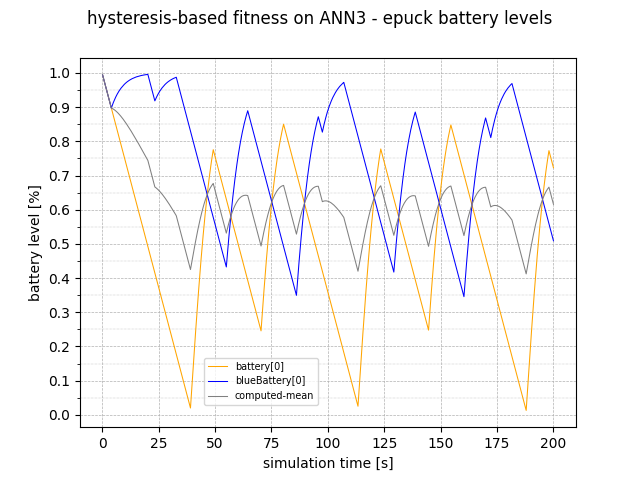

In [300]:
fig = plt.figure()
ax = fig.gca()
yb = dfyb.plot(x="time", y="battery[0]", ax=ax, c="orange", linewidth=0.75, legend=False)
bb = dfbb.plot(x="time", y="blueBattery[0]", ax=ax, c="blue", linewidth=0.75, legend=False)
mean = dfstat.plot(x="time", y="mean", ax=ax, c="grey", linewidth=0.75, label="computed-mean", legend=False)
ax.patch.set_visible(False)

In [301]:
# tag rows based on the threshold
dfstat['zero'] = (dfyb['battery[0]'] == dfbb['blueBattery[0]']) & (dfyb['battery[0]'] == 0)

# first row is a True preceded by a False
fst = dfstat.index[dfstat['zero'] & ~ dfstat['zero'].shift(1).fillna(False)]

# last row is a True followed by a False
lst = dfstat.index[dfstat['zero'] & ~ dfstat['zero'].shift(-1).fillna(False)]

# filter those which are adequately apart
depleted_regions = [(i, j) for i, j in zip(fst, lst)]
depleted_regions

[]

In [302]:
# paint red squares for the regions with no charge
for tup in depleted_regions:
    avs = ax.axvspan(dfyb.iloc[tup[0]]["time"], dfyb.iloc[tup[1]]["time"], alpha=0.15, color='red', label = "NoBattery")

In [303]:
ax.set_xlabel("simulation time [s]")
ax.set_ylabel("battery level [%]")
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(bottom=0.25)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('hysteresis-based fitness on ANN3 - epuck battery levels')
yb = ax.get_position()
ax.legend(fontsize="x-small", loc=(axbox.x1 - 0.65, axbox.y0 - 0.05))

In [304]:
fig.savefig("figures/ann3_schmitt_battery.pdf", bbox_inches='tight')

## hysteresis-based light sensors analysis

In [305]:
dfbl = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-ANN3/outputFiles/layer4Output", sep=" ", header=None, names=["time", "bl0", "bl7"], usecols=[0, 1, 8])
dfyl = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-ANN3/outputFiles/layer2Output", sep=" ", header=None, names=["time", "l0", "l7"], usecols=[0, 1, 8])
dfbl["l0"] = dfyl["l0"]
dfbl["l7"] = dfyl["l7"]
dfbl["bmean"] = dfbl[["bl0", "bl7"]].mean(axis=1)
dfbl["ymean"] = dfbl[["l0", "l7"]].mean(axis=1)
dfbl = dfbl[:2001]
dfbl

,time,bl0,bl7,l0,l7,bmean,ymean
0,0.0,0.0000,0.0000,0.4428,0.0,0.00000,0.2214
1,0.1,0.0000,0.0000,0.2806,0.0,0.00000,0.1403
2,0.2,0.0000,0.0000,0.1070,0.0,0.00000,0.0535
3,0.3,0.0000,0.0000,0.0000,0.0,0.00000,0.0000
4,0.4,0.0000,0.0000,0.0000,0.0,0.00000,0.0000
...,...,...,...,...,...,...,...
1996,199.6,0.5692,0.5694,0.0000,0.0,0.56930,0.0000
1997,199.7,0.5689,0.5732,0.0000,0.0,0.57105,0.0000
1998,199.8,0.5685,0.5770,0.0000,0.0,0.57275,0.0000
1999,199.9,0.5681,0.5809,0.0000,0.0,0.57450,0.0000


<IPython.core.display.Javascript object>


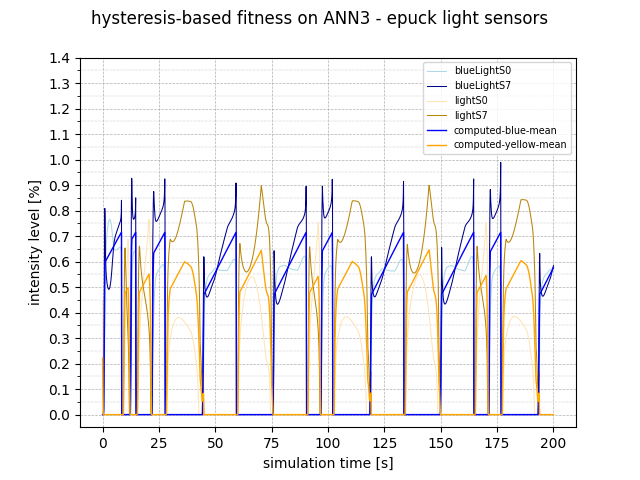

In [306]:
fig = plt.figure()
ax = fig.gca()
bl0 = dfbl.plot(x="time", y="bl0", ax=ax, c="lightblue", linewidth=0.75, label="blueLightS0", legend=False)
bl7 = dfbl.plot(x="time", y="bl7", ax=ax, c="darkblue", linewidth=0.75, label="blueLightS7", legend=False)
l0 = dfbl.plot(x="time", y="l0", ax=ax, c="moccasin", linewidth=0.75, label="lightS0", legend=False)
l7 = dfbl.plot(x="time", y="l7", ax=ax, c="darkgoldenrod", linewidth=0.75, label="lightS7", legend=False)
bmean = dfbl.plot(x="time", y="bmean", ax=ax, c="blue", linewidth=1, label="computed-blue-mean", legend=False)
ymean = dfbl.plot(x="time", y="ymean", ax=ax, c="orange", linewidth=1, label="computed-yellow-mean", legend=False)
ax.patch.set_visible(False)

In [307]:
ax.set_xlabel("simulation time [s]")
ax.set_ylabel("intensity level [%]")
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(top=1.4)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('hysteresis-based fitness on ANN3 - epuck light sensors')
yb = ax.get_position()
ax.legend(fontsize="x-small", loc=0)

In [308]:
fig.savefig("figures/ann3_schmitt_light.pdf", bbox_inches='tight')

# CTRNN analysis

## hysteresis-based function analysis

In [14]:
dff = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-CTRNNosc/geneticDataFiles/fitness.log", sep="\t", header=None, names=["gen", "best", "avg", "worst"], comment="#")
dff = dff[:1001]
dff.describe()

,gen,best,avg,worst
count,730.000000,730.000000,730.000000,730.0
mean,364.500000,0.651350,0.340971,0.0
std,210.877136,0.050965,0.040933,0.0
min,0.000000,0.559362,0.072441,0.0
25%,182.250000,0.593091,0.314618,0.0
50%,364.500000,0.694117,0.340173,0.0
75%,546.750000,0.699539,0.369576,0.0
max,729.000000,0.699539,0.448793,0.0


<IPython.core.display.Javascript object>


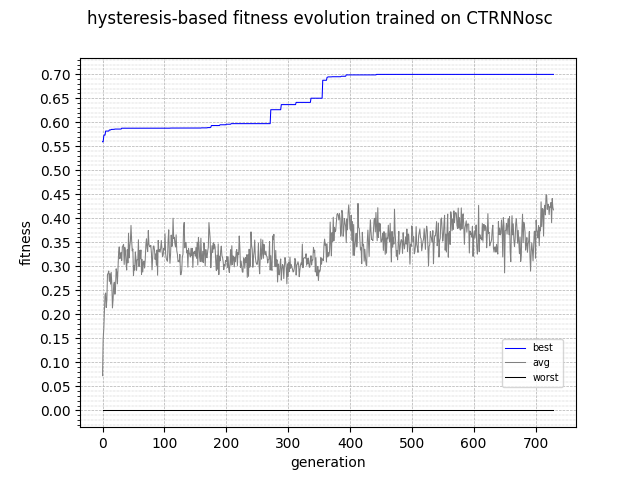

In [15]:
fig = plt.figure()
ax = fig.gca()
bestf = dff.plot(x="gen", y="best", ax=ax, c="blue", linewidth=0.75, legend=False)
avgf = dff.plot(x="gen", y="avg", ax=ax, c="grey", linewidth=0.75, legend=False)
worstf = dff.plot(x="gen", y="worst", ax=ax, c="black", linewidth=0.75, legend=False)
ax.patch.set_visible(False)

In [16]:
ax.set_xlabel("generation")
ax.set_ylabel("fitness")
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
#ax.set_ylim(bottom=0.25)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('hysteresis-based fitness evolution trained on CTRNNosc')
axbox = ax.get_position()
ax.legend(fontsize="x-small", loc=(axbox.x1 - 0.05, axbox.y0))

In [17]:
fig.savefig("figures/ctrnnosc_schmitt_fitness.pdf", bbox_inches='tight')

## hysteresis-based battery charge analysis

In [19]:
dfyb = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-CTRNNosc/outputFiles/layer1Output", sep=" ", header=0, names=["time", "input", "battery[0]", "nan"], usecols=[0, 1, 2])
dfbb = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-CTRNNosc/outputFiles/layer3Output", sep=" ", header=0, names=["time", "input", "blueBattery[0]", "nan"], usecols=[0, 1, 2])
dfyb = dfyb[:2001]
dfbb = dfbb[:2001]
dfstat = dfyb[["time"]].copy()
dfstat["yb"] = dfyb[["battery[0]"]].copy()
dfstat["bb"] = dfbb[["blueBattery[0]"]].copy()
dfstat["mean"] = dfstat[["yb", "bb"]].mean(axis=1)
dfstat

,time,yb,bb,mean
0,0.1,0.990,0.9900,0.9900
1,0.2,0.985,0.9850,0.9850
2,0.3,0.980,0.9800,0.9800
3,0.4,0.975,0.9750,0.9750
4,0.5,0.970,0.9700,0.9700
...,...,...,...,...
1996,199.7,0.000,0.4134,0.2067
1997,199.8,0.000,0.4084,0.2042
1998,199.9,0.000,0.4034,0.2017
1999,200.0,0.000,0.3984,0.1992


<IPython.core.display.Javascript object>


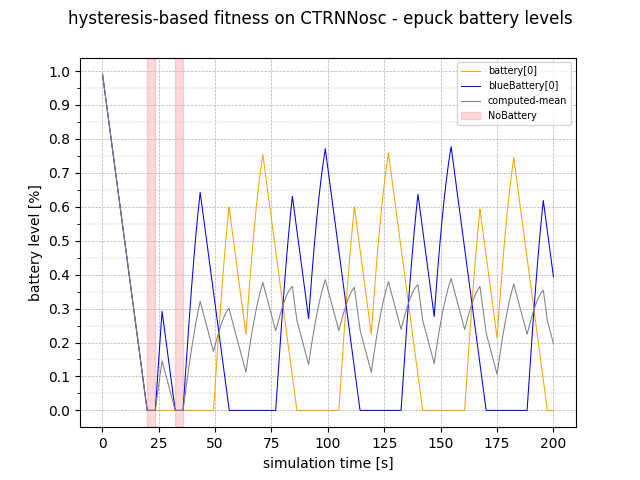

In [31]:
fig = plt.figure()
ax = fig.gca()
yb = dfyb.plot(x="time", y="battery[0]", ax=ax, c="orange", linewidth=0.75, legend=False)
bb = dfbb.plot(x="time", y="blueBattery[0]", ax=ax, c="blue", linewidth=0.75, legend=False)
mean = dfstat.plot(x="time", y="mean", ax=ax, c="grey", linewidth=0.75, label="computed-mean", legend=False)
ax.patch.set_visible(False)

In [32]:
# tag rows based on the threshold
dfstat['zero'] = (dfyb['battery[0]'] == dfbb['blueBattery[0]']) & (dfyb['battery[0]'] == 0)

# first row is a True preceded by a False
fst = dfstat.index[dfstat['zero'] & ~ dfstat['zero'].shift(1).fillna(False)]

# last row is a True followed by a False
lst = dfstat.index[dfstat['zero'] & ~ dfstat['zero'].shift(-1).fillna(False)]

# filter those which are adequately apart
depleted_regions = [(i, j) for i, j in zip(fst, lst)]
depleted_regions

[(198, 234), (323, 357)]

In [33]:
# paint red squares for the regions with no charge
for tup in depleted_regions:
    avs = ax.axvspan(dfyb.iloc[tup[0]]["time"], dfyb.iloc[tup[1]]["time"], alpha=0.15, color='red', label = "NoBattery")

In [34]:
ax.set_xlabel("simulation time [s]")
ax.set_ylabel("battery level [%]")
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(bottom=0.25)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('hysteresis-based fitness on CTRNNosc - epuck battery levels')
lns = [yb.get_lines()[0]] + [bb.get_lines()[1]] + [bb.get_lines()[2]] + [avs]
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, fontsize="x-small", loc=0)

In [35]:
fig.savefig("figures/ctrnnosc_schmitt_battery.pdf", bbox_inches='tight')

## hysteresis-based light sensors analysis

In [43]:
dfbl = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-CTRNNosc/outputFiles/layer4Output", sep=" ", header=None, names=["time", "bl0", "bl7"], usecols=[0, 1, 8])
dfyl = pd.read_csv("/home/marcos/OneDrive/home/ETSIT/tercero/irin/o2/sim/code/training/schmitt/irsim-CTRNNosc/outputFiles/layer2Output", sep=" ", header=None, names=["time", "l0", "l7"], usecols=[0, 1, 8])
dfbl["l0"] = dfyl["l0"]
dfbl["l7"] = dfyl["l7"]
dfbl["bmean"] = dfbl[["bl0", "bl7"]].mean(axis=1)
dfbl["ymean"] = dfbl[["l0", "l7"]].mean(axis=1)
dfbl = dfbl[:2001]
dfbl

,time,bl0,bl7,l0,l7,bmean,ymean
0,0.0,0.0,0.0,0.4428,0.0,0.0,0.22140
1,0.1,0.0,0.0,0.4352,0.0,0.0,0.21760
2,0.2,0.0,0.0,0.4272,0.0,0.0,0.21360
3,0.3,0.0,0.0,0.4191,0.0,0.0,0.20955
4,0.4,0.0,0.0,0.4107,0.0,0.0,0.20535
...,...,...,...,...,...,...,...
1996,199.6,0.0,0.0,0.0000,0.0,0.0,0.00000
1997,199.7,0.0,0.0,0.0000,0.0,0.0,0.00000
1998,199.8,0.0,0.0,0.0000,0.0,0.0,0.00000
1999,199.9,0.0,0.0,0.0000,0.0,0.0,0.00000


<IPython.core.display.Javascript object>


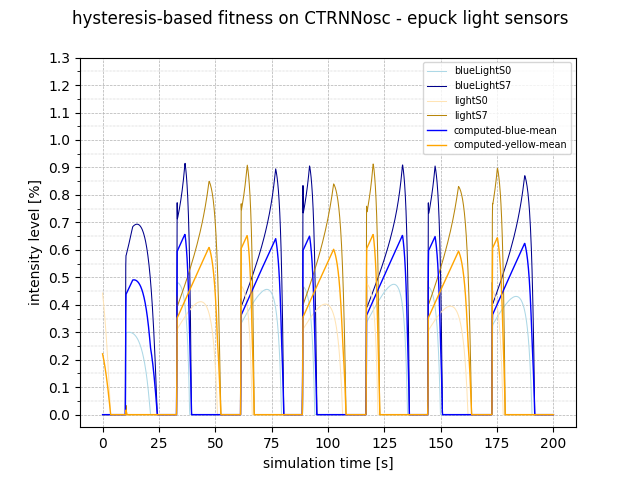

In [44]:
fig = plt.figure()
ax = fig.gca()
bl0 = dfbl.plot(x="time", y="bl0", ax=ax, c="lightblue", linewidth=0.75, label="blueLightS0", legend=False)
bl7 = dfbl.plot(x="time", y="bl7", ax=ax, c="darkblue", linewidth=0.75, label="blueLightS7", legend=False)
l0 = dfbl.plot(x="time", y="l0", ax=ax, c="moccasin", linewidth=0.75, label="lightS0", legend=False)
l7 = dfbl.plot(x="time", y="l7", ax=ax, c="darkgoldenrod", linewidth=0.75, label="lightS7", legend=False)
bmean = dfbl.plot(x="time", y="bmean", ax=ax, c="blue", linewidth=1, label="computed-blue-mean", legend=False)
ymean = dfbl.plot(x="time", y="ymean", ax=ax, c="orange", linewidth=1, label="computed-yellow-mean", legend=False)
ax.patch.set_visible(False)

In [45]:
ax.set_xlabel("simulation time [s]")
ax.set_ylabel("intensity level [%]")
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(top=1.3)
#ax.tick_params(axis='both', which='minor', labelsize=6)
ax.grid(linestyle='--', linewidth=0.5, which="major")
ax.grid(linestyle='-.', linewidth=0.25, which="minor")
fig.suptitle('hysteresis-based fitness on CTRNNosc - epuck light sensors')
yb = ax.get_position()
ax.legend(fontsize="x-small", loc=0)

In [46]:
fig.savefig("figures/ctrnnosc_schmitt_light.pdf", bbox_inches='tight')